<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Bayesian Estimation and Regression with `pymc3`


---

## Learning Objectives

### Core

- Know that `pymc3` uses Markov-Chain Monte-Carlo methods to create samples from the posterior distribution
- [Conduct a Frequentist hypothesis test using `stats.ttest_ind()` and explain why you reject or fail to reject the null hypothesis](#freq-ttest)
- [Conduct a Bayesian hypothesis test with `pymc3`](#priors)
- [Conduct Bayesian regression with `pymc3`](#reg)
- Copy and paste the code for the `pymc3` model, and understand which parts of the code you need to change to suit your investigation
- Interpret the plots/print-outs that you get with `pm.plot_posterior`, `pm.summary`,  `pm.trace_to_dataframe`, and `pm.traceplot`


### Target

- [Set up a `pymc3` model using a patsy formula](#formula)
- Plot different possible regression lines using `pm.glm.plot_posterior_predictive`
- Explain the different choices for the distributions used for the priors and likelihoods (uniform and normal in these examples)


### Lesson Guide
- [Introduction](#intro)
- [Enter `pymc3`](#pymc3)
- [Load the Starcraft data](#data)
- [Alternative to t-testing using Bayesian estimation](#ttest)
    - [Get the APM values for 19 and 26 year olds](#load)
    - [Perform a Frequentist t-test of the mean APM difference between groups](#freq-ttest)
    - [Set up a Bayesian model with priors on the mean APMs](#priors)
    - [Construct the prior distributions on the means](#construct-priors)
    - [Construct the prior distributions on the standard deviations](#std-priors)
    - [Set up the APM distributions for the two groups](#apm-dists)
    - [Tracking additional metrics](#metrics)
    - [Fitting the `pymc3` model](#fit)
    - [Plotting the posteriors and metric distributions](#plotting)
- [Bayesian regression with `pymc3`](#reg)
    - [Set up variables to perform an age vs. APM regression](#age-vs-apm)
    - [Set up the Bayesian regression model](#bayes-model)
    - [Plot the posteriors using `pm.traceplot`](#traceplot)
- [Using a patsy-style formula to specify a `pymc3` model](#formula)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction
---

With `pymc3` we can perform the Bayesian counterparts of Frequentist models we have studied. In this codealong lesson we will start incrementally: first replacing the Frequentist t-test with Bayesian estimation and then performing a Bayesian regression with a single predictor.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=4)
pd.set_option('precision',4)

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='pymc3'></a>
## Enter `pymc3`
---

`Pymc3` is the Bayesian modeling package we will be using. It is a powerful and flexible architecture for performing a huge variety of Bayesian analyses. We will only be scratching the surface today.

In [2]:
import pymc3 as pm

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<a id='data'></a>
### Load the Starcraft dataset
---

This dataset has records of different player statistics in competitive Starcraft. There are a variety of columns that are described in detail within the `description.txt` file contained inside the `resource-datasets/` folder.

For the examples in this lab, we will be using APM (actions per minute) and Age, but you might want to look at other variables as well.

In [3]:
star = pd.read_csv('../../../../resource-datasets/starcraft/SkillCraft1_Dataset.csv')

In [4]:
star.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.0035,0.0002,7,1.0985e-04,0.0004,0.0048,32.6677,40.8673,4.7508,28,0.0014,6,0.0,0.0000e+00
1,55,5,23,10,5000,129.2322,0.0033,0.0003,4,2.9406e-04,0.0004,0.0043,32.9194,42.3454,4.8434,22,0.0012,5,0.0,2.0757e-04
2,56,4,30,10,200,69.9612,0.0011,0.0003,4,2.9362e-04,0.0005,0.0029,44.6475,75.3548,4.0430,22,0.0007,6,0.0,1.8876e-04
3,57,3,19,20,400,107.6016,0.0010,0.0002,1,5.3275e-05,0.0005,0.0038,29.2203,53.7352,4.9155,19,0.0004,7,0.0,3.8358e-04
4,58,3,32,10,500,122.8908,0.0011,0.0003,2,0.0000e+00,0.0013,0.0024,22.6885,62.0813,9.3740,15,0.0012,4,0.0,1.9254e-05


<a id='ttest'></a>
## Alternative to t-testing using Bayesian estimation
---

[This example is adapted from the documentation here.](http://pymc-devs.github.io/pymc3/notebooks/BEST.html) 

> **Note:** In that example the Student t distribution is used instead of the normal distribution like below. This is more appropriate, but more complicated due to the parameterization of the t-distribution. If you're feeling bold try doing this with the t-distribution like in the documentation!

In the following code, we will be using Bayesian posterior estimation to look at the difference in APM between 19 year old players and 26 year old players.

### The Frequentist strategy

In Frequentist statistics, calculating the mean difference between groups is typically done with a t-test. In a t-test we state a null hypothesis (H0) that there is no difference between groups, then evaluate the probability that we could have got this data if the null hypothesis were true.

The de-facto standard for statistically comparing two (or more) samples is to use a statistical test. This involves expressing a null hypothesis, which typically claims that there is no difference between the groups, and using a chosen test statistic to determine whether the distribution of the observed data is plausible under the hypothesis. The rejection occurs when the calculated test statistic is higher than some pre-specified threshold value.

### The Bayesian strategy

The Bayesian approach for evaluating differences between groups is "estimation" rather than "testing". Instead of asking "are the two groups different?", we instead ask "_how_ different are the two groups?" This is the subtle difference in estimation as opposed to testing. We are measuring the extent of the difference between the groups, whether it be zero or any other value.

For a more detailed treatment read the documentation linked above.

<a id='load'></a>
### Get the APM for 19 and 26 year olds

In [5]:
apm19 = star[star.Age == '19'].APM
apm26 = star[star.Age == '26'].APM

In [6]:
print(apm19.shape, apm26.shape)

(313,) (136,)


**Calculate the mean for the two groups and the empirical difference between means.**

In [7]:
print(apm19.mean(), apm26.mean(), apm26.mean()-apm19.mean())

121.68955974440884 104.7418407352942 -16.947719009114635


<a id='freq-ttest'></a>
### Perform a Frequentist t-test of the mean APM difference between groups.

What is the null hypothesis? What is the alternative hypothesis?

- The null hypothesis is that there is no difference between the mean APM.
- The alternative hypothesis is that there IS a difference.

In [8]:
import scipy.stats as stats

In [9]:
tt = stats.ttest_ind(apm19, apm26)

In [10]:
print('t-statistic:\t', tt.statistic)
print('p-value:\t', tt.pvalue)

t-statistic:	 3.5501270512716077
p-value:	 0.00042586927952623034


**Plot the t-statistic for the test on the t-distribution.**

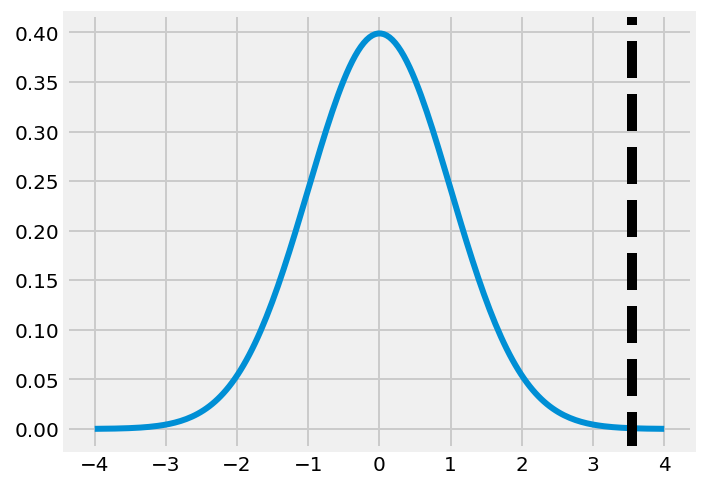

In [11]:
zdist = stats.norm(0, 1)
xvals = np.linspace(-4, 4, 200)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(xvals, zdist.pdf(xvals), lw=3)
ax.axvline(tt.statistic, color='black', ls='dashed', lw=5)
plt.show()

<a id='priors'></a>
### Set up the Bayesian model with priors on mean APMs

Next we'll go through the steps of the Bayesian estimation of the difference between means using `pymc3`.

First we find the mean and standard deviation of APM regardless of age group. We can  use these values to inform our prior belief about APM.

In [12]:
mean_prior_mean = star.APM.mean()
mean_prior_std = star.APM.std()

print(mean_prior_mean, mean_prior_std)

117.04694709278338 51.94529098683481


<a id='construct-priors'></a>
### Construct the prior distributions on the means

> **Note**: `pymc3` sets up models using the Python `with ... :` syntax.

The first thing we are going to set up is our prior belief about the mean APM for our 19 year olds and 26 year olds. _These are not fixed values,_ but rather normal distributions covering a range of possible values for the mean APM for each group with varying likelihoods.

We are going to set up the normal distributions to both take the overall mean and standard deviation of the actions per minute for all players. In other words, our prior belief for each group's mean APM is the same.

In [13]:
# create the model instance
with pm.Model() as model:
    
    # priors for the mean
    group19_mean = pm.Normal('APM_19yo_mean', mu=mean_prior_mean, sd=mean_prior_std)
    group26_mean = pm.Normal('APM_26yo_mean', mu=mean_prior_mean, sd=mean_prior_std)

<a id='std-priors'></a>
### Priors on standard deviations

What we set up before are the prior distributions for the _means_ of APM for the two age groups, but we can also set up priors on the standard deviations for APM for each group.

Our standard deviation priors can be "uninformative": uniformly distributed from close to 0 up to 100. We are saying that we believe all standard deviations in those ranges to be equally likely.

In [14]:
std_prior_lower = 0.00001
std_prior_upper = 100.

with model:
    
    # priors for the standard deviations
    group19_std = pm.Uniform('APM_19yo_std', lower=std_prior_lower, upper=std_prior_upper)
    group26_std = pm.Uniform('APM_26yo_std', lower=std_prior_lower, upper=std_prior_upper)

<a id='apm-dists'></a>
### Set up the APM distributions for the two groups

Now that we have our prior beliefs about the mean and standard deviation of APM for each age group, we can construct what will be the likelihood functions for "observing" the APMs given each group's mean and standard deviation.

For each group we set up a `pm.Normal` distribution to represent the likelihood function of APM. The mean `mu=` will stem from our prior belief distribution of the mean for that group. Likewise the `sd=` will stem from the prior distribution for standard deviation of APM for that group. 

Lastly, we provide the vectors of data for the `observed=` parameter. This is the actual, measured APM data. When we "fit" this model (using MCMC or another sampling strategy under the hood), the posterior distributions will be updated according to our prior beliefs and our data – just like in Bayes' formula!

In [15]:
with model:
    # likelihood functions for the age group apms
    # the likelihood functions make use of the observed data
    # and refer to the prior distributions
    group19 = pm.Normal('APM_19yo', mu=group19_mean, sd=group19_std, observed=apm19)
    group26 = pm.Normal('APM_26yo', mu=group26_mean, sd=group26_std, observed=apm26)

<a id='metrics'></a>
### Tracking additional metrics

The last thing we'll do before fitting the model is define some distributions that will make it easier for us to evaluate the difference between mean APMs of the two groups. 

`pm.Deterministic` distributions are defined from other distributions in the model. For example, we can set up `diff_of_means` to be defined by `group19_mean - group26_mean`, making this a distribution of the differences between means between groups as the posteriors are iteratively fit/estimated.

In [16]:
with model:
    
    # create deterministic distributions for the parameter differences
    diff_of_means = pm.Deterministic('mean_diff', group19_mean - group26_mean)
    diff_of_stds = pm.Deterministic('std_diff', group19_std - group26_std)

<a id='fit'></a>
### Fitting the `pymc3` model

When we call `trace = pm.sample(...)` we are starting a sampling process to estimate the posterior distribution. `Pymc3` defaults to the NUTS sampler. NUTS stands for No U-Turn Sampler and is a state-of-the-art posterior estimation algorithm. Other well-established Markov-Chain-Monte-Carlo (MCMC) algorithms are available.

The "trace" is a collection of all the values on the posterior distribution "visited" during the sampling procedure. The values in the trace define the posterior distribution.

In [17]:
with model:
    
    # create samples from the posterior distribution
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [APM_26yo_std_interval__, APM_19yo_std_interval__, APM_26yo_mean, APM_19yo_mean]
100%|██████████| 5500/5500 [00:06<00:00, 864.74it/s]


### The model that we created

In [18]:
model

<a id='plotting'></a>
### Plotting the posteriors and metric distributions

`Pymc3` comes with convenient methods for plotting posteriors. Below we plot our posterior means and standard deviations. The relevant statistics about the distributions are automatically added to the plots.

The HPD is the Highest Posterior Density interval. This gives us a Bayesian "credible interval" which is the corollary to the Frequentist confidence interval. The 95% HPD says that the 95% highest density points on the distribution fall within that range.

**Take a look at the first element of the `trace`:**

In [19]:
trace[0]

{'APM_19yo_mean': 115.77506236568665,
 'APM_19yo_std': 54.11225503960674,
 'APM_19yo_std_interval__': 0.16486241399399512,
 'APM_26yo_mean': 102.57538968818689,
 'APM_26yo_std': 44.338668578742826,
 'APM_26yo_std_interval__': -0.22742872576600623,
 'mean_diff': 13.199672677499763,
 'std_diff': 9.77358646086391}

**Use the `pm.plot_posterior` function to look at the posterior distributions for the group means and standard deviations.**

> **Note:** It is common to slice off the initial portion of the trace. This is known as the "burn-in". The sampling procedure often starts far away from the correct estimates, and so slicing off the beginning can get rid of the cruft. For that reason, by default, sampling includes 500 initial steps that are discarded. If internal tests indicate that more such steps are needed, you can either increase the values for the parameter `tune` or heuristically discard the first portion of the trace (potentially based on running some tests yourself). It is also common to not take every sample, but skip every two or three. We will not do that here. You can check that doing so virtually makes no difference.

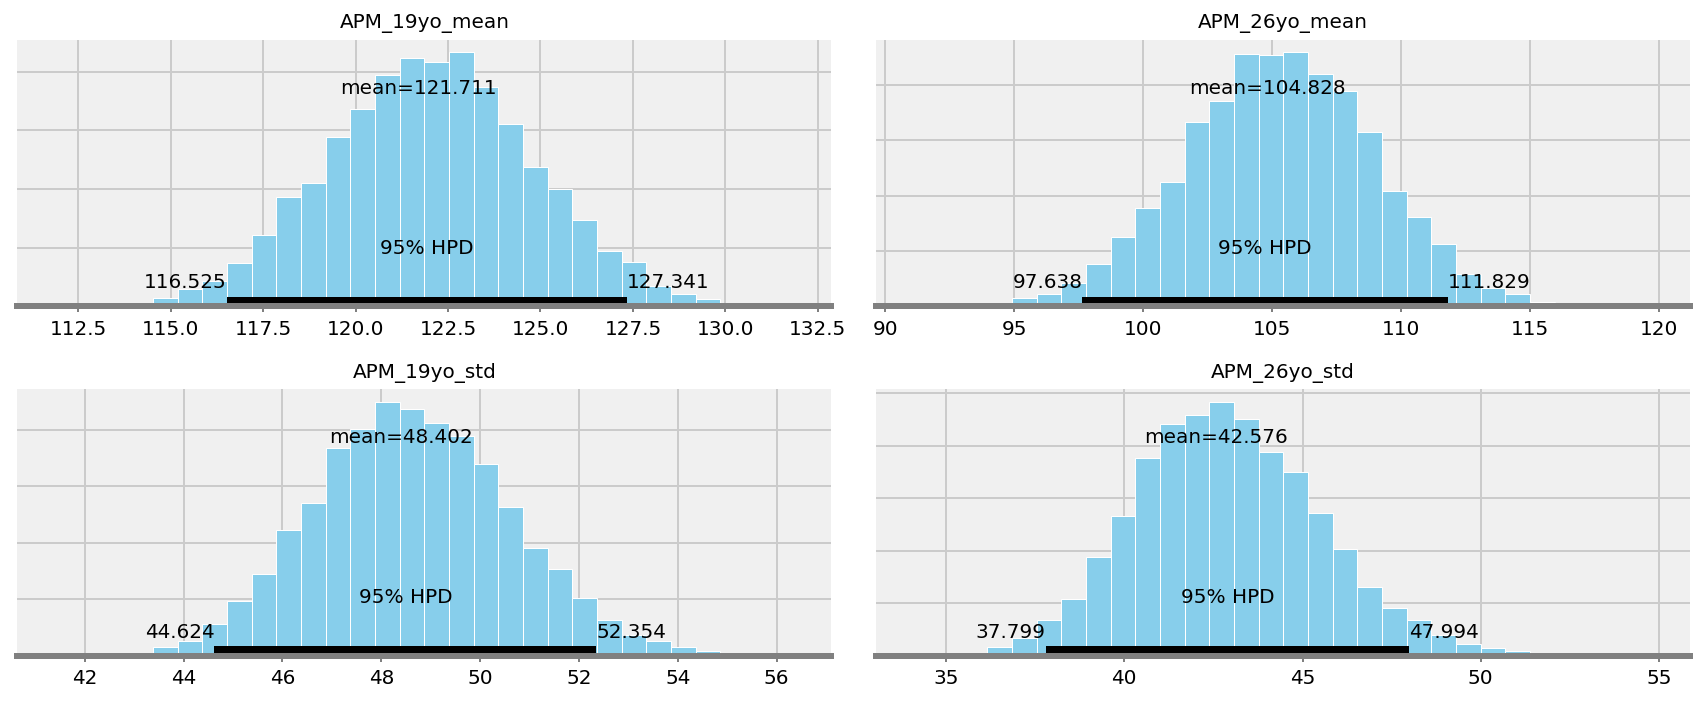

In [20]:
pm.plot_posterior(trace[500:],
                  varnames=['APM_19yo_mean', 'APM_26yo_mean',
                            'APM_19yo_std', 'APM_26yo_std'],
                  color='#87ceeb')
plt.show()

**Plot the posteriors of our metric distributions.**

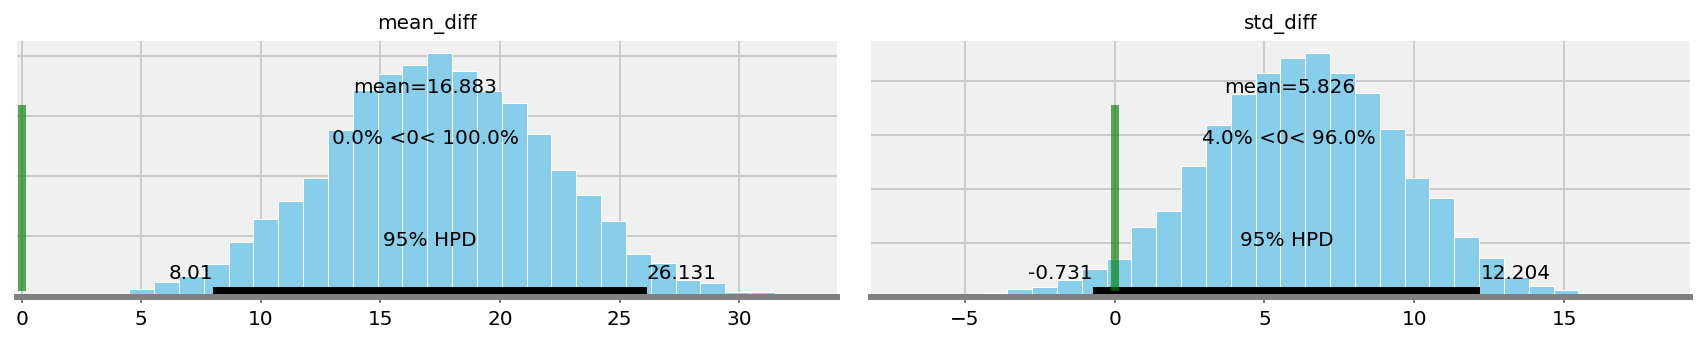

In [21]:
pm.plot_posterior(trace[500:],
                  varnames=['mean_diff', 'std_diff'],
                  color='#87ceeb', ref_val=0)
plt.show()

#### The traceplot shows kernel density estimates of the distributions (left) and how the chains evolve (right).

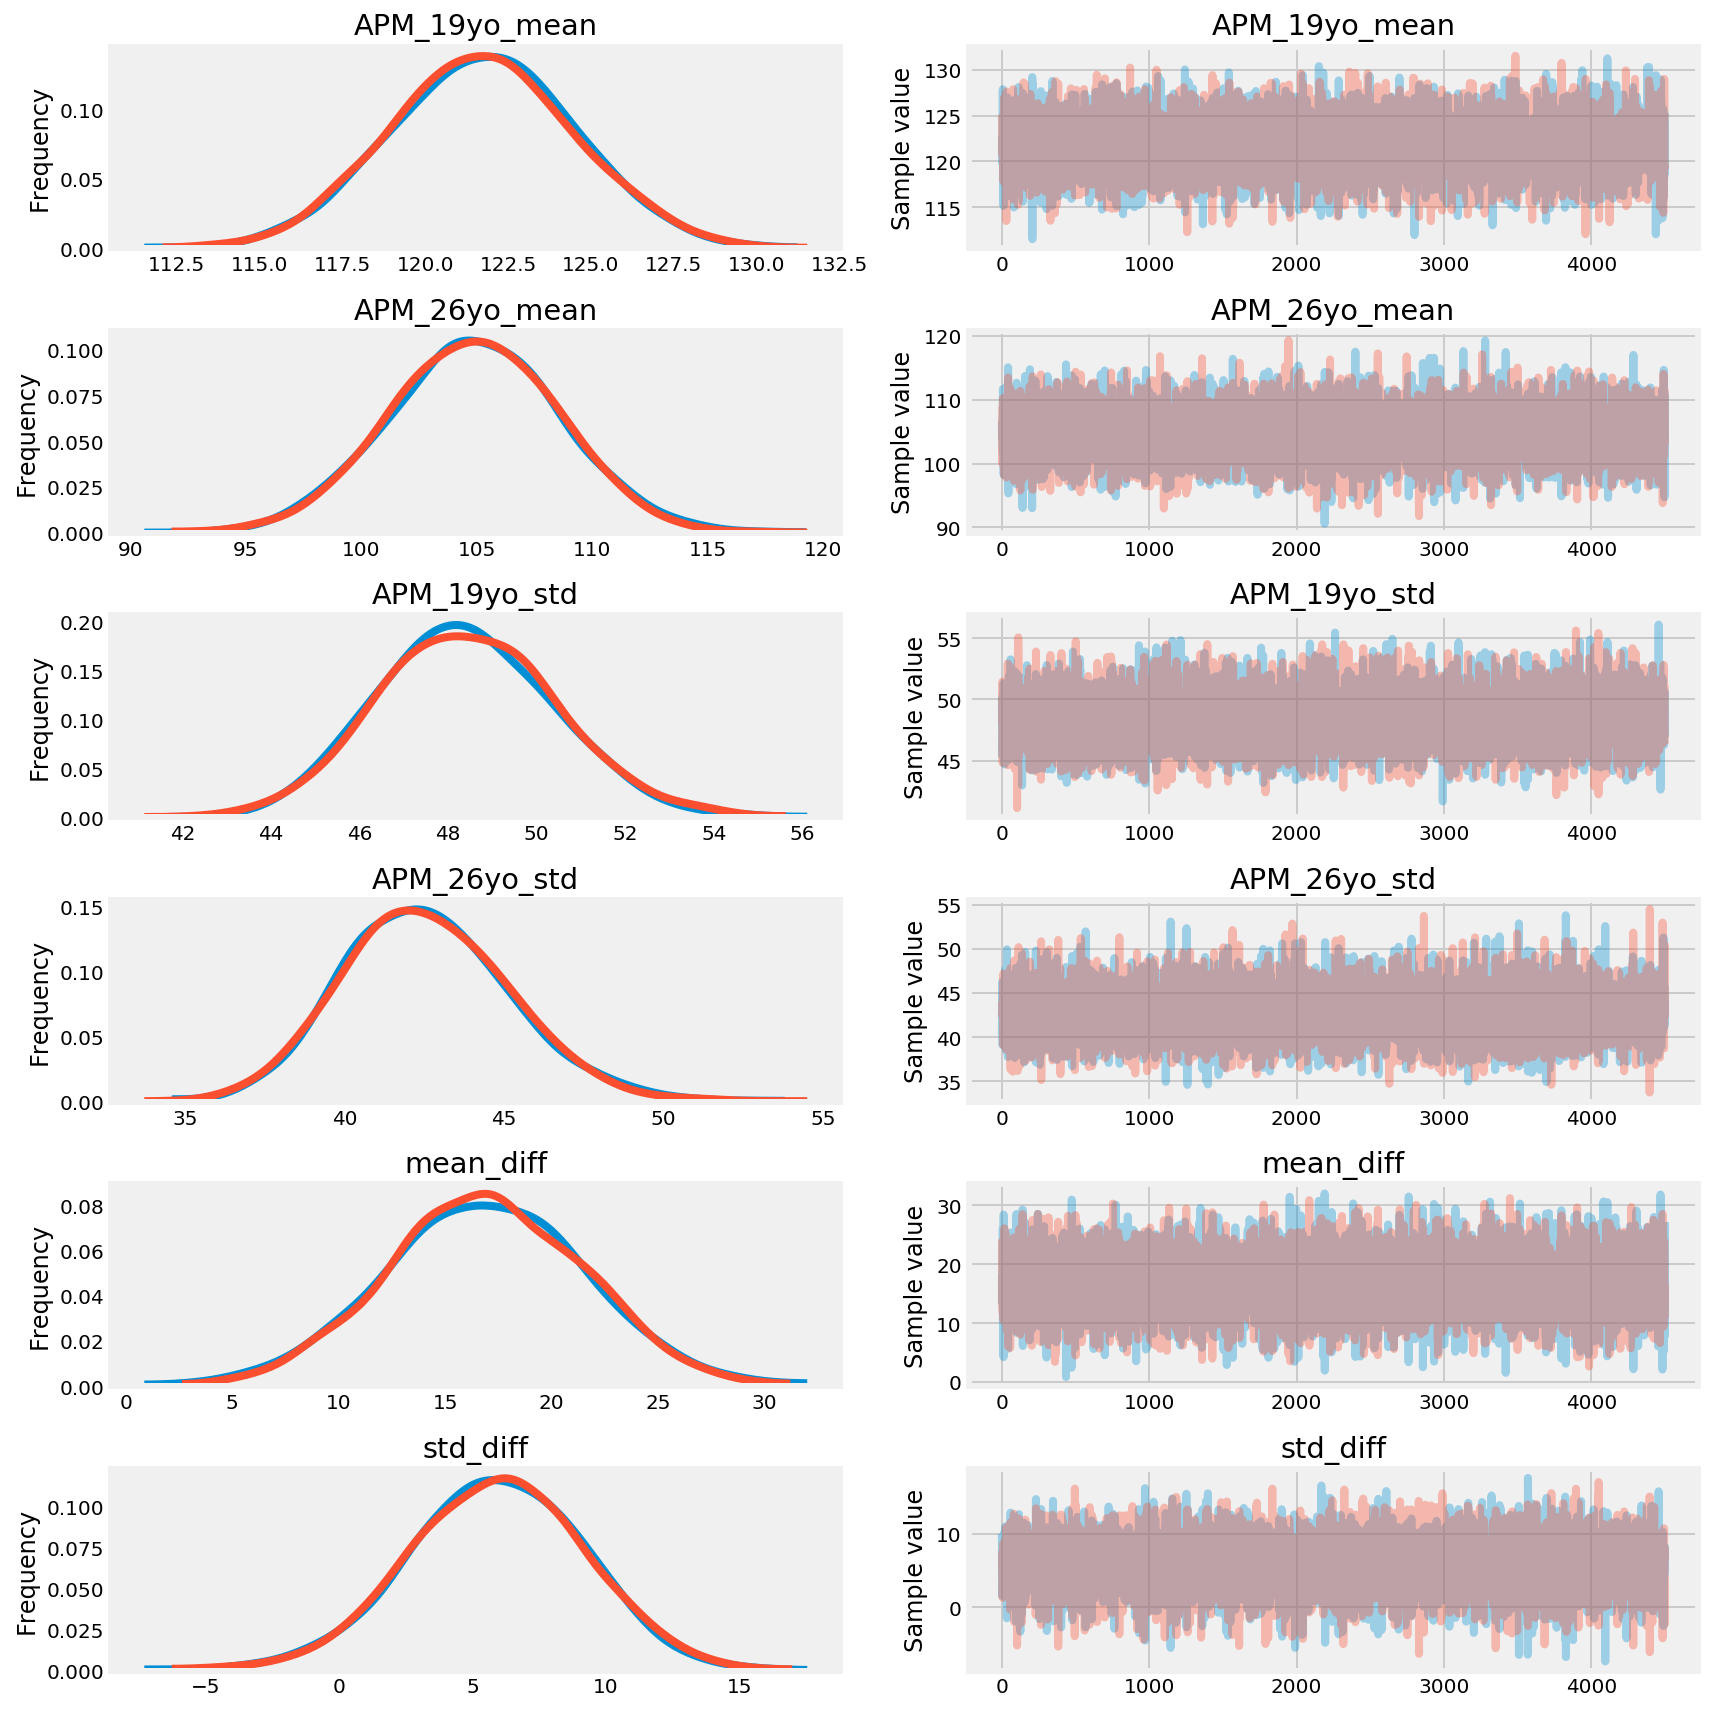

In [22]:
pm.traceplot(trace[500:],combined=False)
plt.tight_layout()
plt.show()

#### The `pm.summary` function can also display a representation of this information:

In [23]:
pm.summary(trace[500:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
APM_19yo_mean,121.7108,2.7811,0.0240,116.5247,127.3414,13905.9428,0.9999
APM_26yo_mean,104.8282,3.6547,0.0345,97.6379,111.8292,13126.5054,1.0000
APM_19yo_std,48.4025,1.9947,0.0183,44.6237,52.3541,12913.5040,0.9999
APM_26yo_std,42.5765,2.6147,0.0236,37.7991,47.9938,12635.1507,0.9999
mean_diff,16.8826,4.6419,0.0405,8.0097,26.1308,13155.0017,0.9999
std_diff,5.8260,3.3047,0.0275,-0.7313,12.2039,13044.5533,0.9999


#### We can collect all the created samples in a dataframe

In [24]:
pm.trace_to_dataframe(trace[500:]).head()

,APM_19yo_mean,APM_26yo_mean,APM_19yo_std,APM_26yo_std,mean_diff,std_diff
0,121.7864,105.5157,50.1920,40.2214,16.2706,9.9706
1,121.5152,104.0924,47.1363,45.5560,17.4228,1.5803
2,122.5224,105.9414,49.0588,40.6427,16.5811,8.4161
3,122.0466,103.9578,45.3879,41.8646,18.0888,3.5233
4,119.7545,106.4516,49.7864,46.3047,13.3029,3.4817


<a id='reg'></a>
## Bayesian regression with `pymc3`
---

With `pymc3`, the sky is the limit. Let's move on to something a little more complicated: Bayesian regressions.

> *Note: [This example is modeled after the generalized linear model (GLM) instructions in the pymc3 documentation.](http://pymc-devs.github.io/pymc3/notebooks/GLM-linear.html)*

What are the benefits to taking a Bayesian approach to regression modeling? Just like in our estimation of means per group, when we perform regression with Bayesian statistics we will get out posterior *distributions* on our intercept and coefficients. 

This is a big difference from the point estimates coming out of the Frequentist regression: not only do we have the most likely value for the coefficients (the MAP estimates), we can see the range of possibilities given our prior and observed data. 

---

<a id='age-vs-apm'></a>
### Set up variables to perform an age vs. APM regression

In [25]:
star.Age.unique()

array(['27', '23', '30', '19', '32', '21', '17', '20', '18', '16', '26',
       '38', '28', '25', '22', '29', '24', '35', '31', '33', '37', '40',
       '34', '43', '41', '36', '44', '39', '?'], dtype=object)

In [26]:
s = star[star.Age != '?']
s.loc[:,'Age'] = s.Age.map(lambda x: float(x))

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [27]:
s.Age.mean()

21.647904191616767

In [28]:
s.isnull().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

#### Plot apm versus age

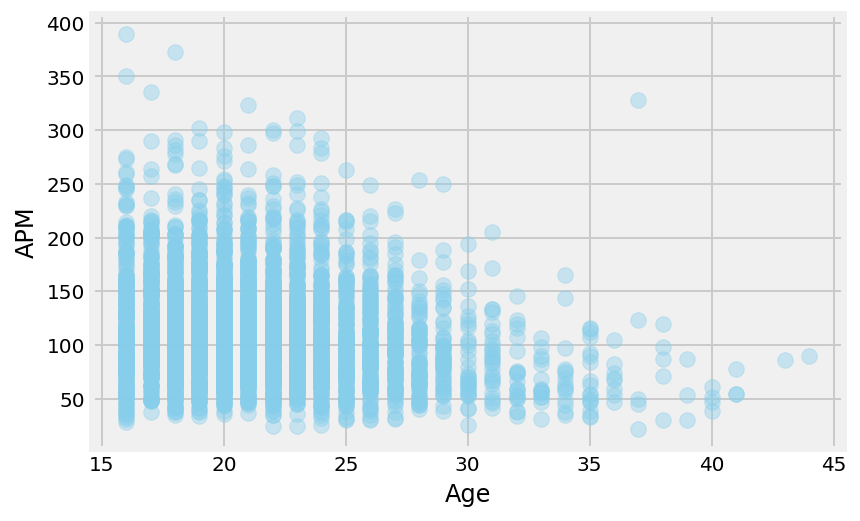

In [29]:
s.plot(kind='scatter',x='Age',y='APM',c='#87ceeb',s=60,alpha=0.4)
plt.show()

<a id='bayes-model'></a>
### Setting up the Bayesian regression model

Like before, we will construct our model with the `with pm.Model() ...` syntax. 

We have three prior distributions in this case that will be updated to posteriors given our observed data:

1. `apm_std`: which will be our prior belief about the standard deviation of APM values. In this case we are setting it to be uniform (uninformative) between `0.0001`, and `1000.`
- `intercept`: a normal distribution for the range of possible values of the intercept.
- `age_beta`: a normal distribution for the range of possible values of the age coefficient.

We set up a `likelihood` distribution that is also normal, representing the distribution of the data (APM) given our predictor. The mean of the likelihood is defined like a regression formula: our intercept distribution plus the age values times our age beta distribution. We give the `apm_std` uniform prior as the standard deviation. Lastly, the observed values, or data, will be the APM values.

What will happen here as we sample from the posterior is that more likely values (as defined by the `mu=` regression-style definition) will be "visited" more often. The intercept and age_beta distributions will have more values visited in places where they result in higher likelihood estimates.

`pm.find_MAP()` tries to find good starting values for our sampling procedure so that we don't have to run it for as many iterations to get a good posterior representation.

In [30]:
apm_age = s[['APM','Age']]

In [31]:
apm_age.describe()

,APM,Age
count,3340.0000,3340.0000
mean,114.5720,21.6479
std,48.0989,4.2063
min,22.0596,16.0000
25%,79.2357,19.0000
50%,107.0703,21.0000
75%,140.1123,24.0000
max,389.8314,44.0000


In [32]:
with pm.Model() as reg:
    
    apm_std = pm.Uniform('error_std', lower=0.0001, upper=1000.)
    
    intercept = pm.Normal('intercept', mu=0, sd=100)#, lower=-10000., upper=10000.)
    age_beta = pm.Normal('age_beta', mu=0, sd=100)#, lower=-200., upper=200.)
    
    # apm ~ b0 + b1 * age
    # E[apm]
    
    E_apm = pm.Normal('y_mean', mu = intercept + (age_beta * apm_age.Age),
                      sd=apm_std, observed=apm_age.APM)

In [33]:
with reg:
    step = pm.NUTS()
    start = pm.find_MAP()
    trace = pm.sample(5000, step=step, start=start, tune=1000)

logp = -17,619, ||grad|| = 4.3633: 100%|██████████| 35/35 [00:00<00:00, 1527.45it/s]         
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [age_beta, intercept, error_std_interval__]
100%|██████████| 6000/6000 [00:21<00:00, 276.83it/s]


<a id='traceplot'></a>
### Plot the posteriors using `pm.traceplot`

The traceplot function can also plot our posteriors, as well as a graph of the actual traces for each distribution. These traces represent the points visited by the sampling algorithm.

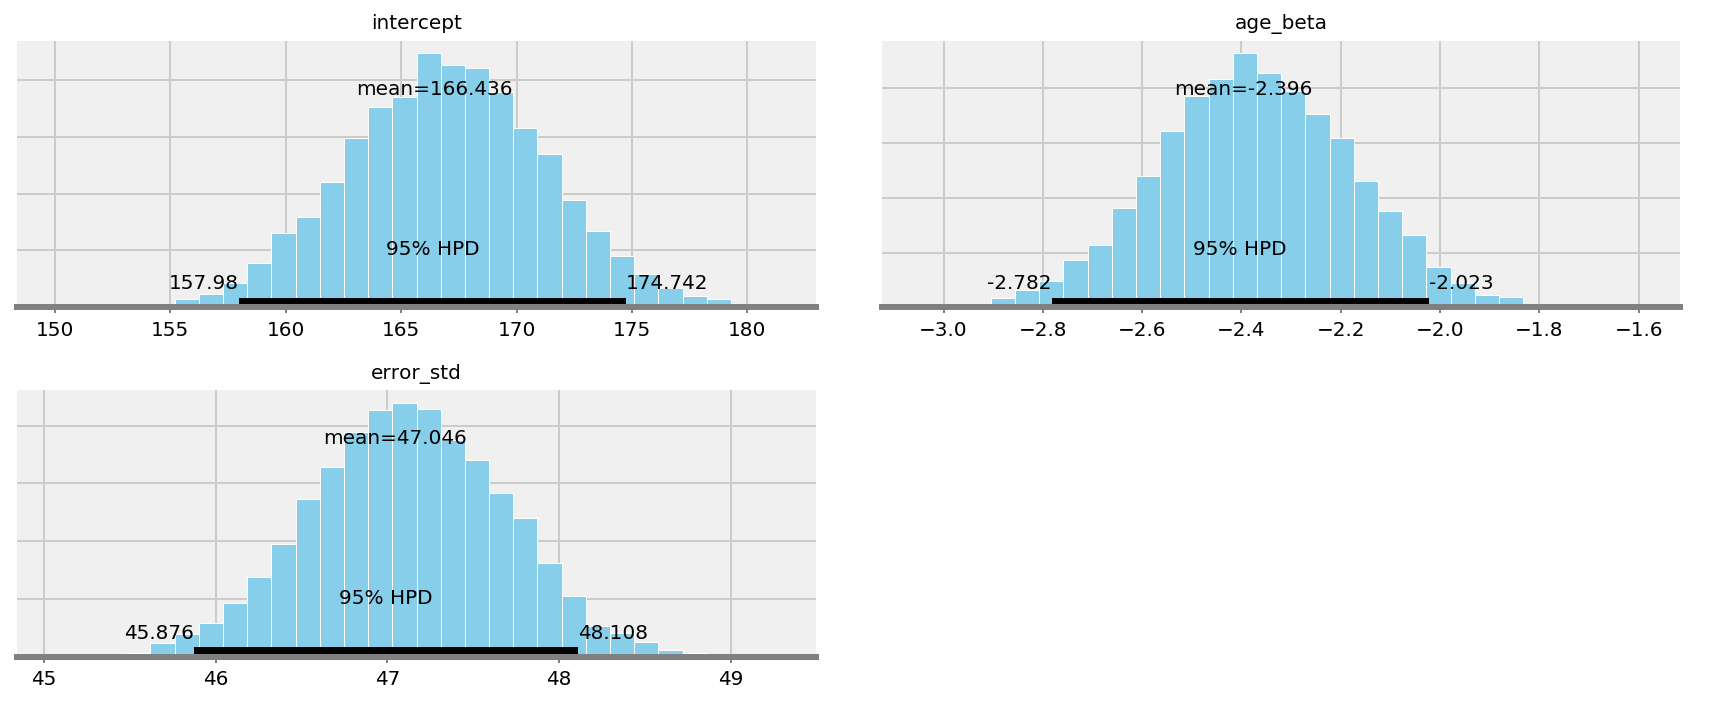

In [34]:
pm.plot_posterior(trace[500:],color='#87ceeb')
plt.show()

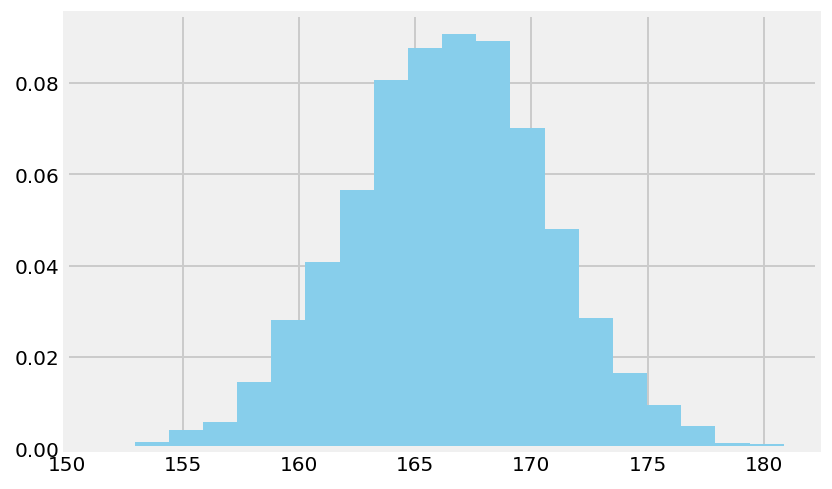

In [35]:
# create one of the histograms ourselves
plt.hist([trace[i]['intercept'] for i in range(500,5000)],bins=20,color='#87ceeb',normed=True)
plt.show()

In [36]:
# that is our model
reg

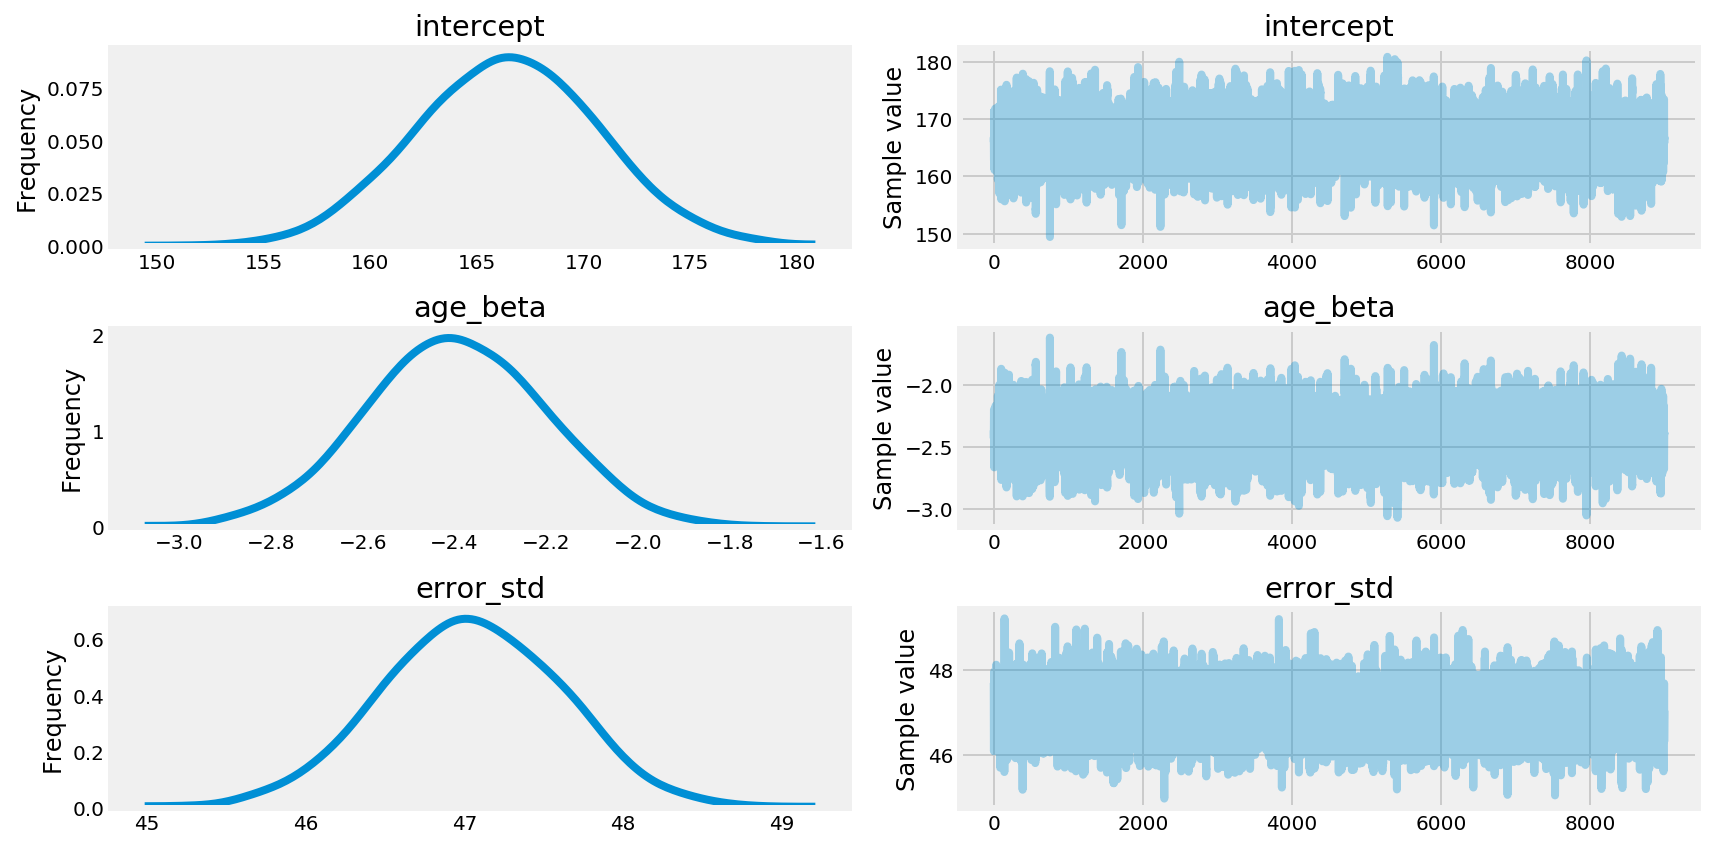

In [37]:
# traceplots
pm.traceplot(trace[500:],combined=True)
plt.tight_layout()
plt.show()

In [38]:
# result summary
pm.summary(trace[500:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
intercept,166.4362,4.3078,0.0659,157.9798,174.7422,3683.1648,0.9999
age_beta,-2.3962,0.1954,0.0030,-2.7822,-2.0232,3630.5220,0.9999
error_std,47.0460,0.5741,0.0074,45.8758,48.1078,4754.2500,1.0001


<a id='formula'></a>
## Setting up a model using a patsy-style formula
---

`Pymc3` also provides a convenience function `pm.glm.glm(...)` which takes a patsy-style formula definition and the dataframe, then automatically constructs the distributions required to solve the Bayesian regression. Pretty nice.

In [39]:
with pm.Model() as reg:
    pm.glm.GLM.from_formula('APM ~ Age', apm_age)
    step = pm.NUTS()
    start = pm.find_MAP()
    trace = pm.sample(10000, step=step, start=start, tune=1000)

logp = -17,613, ||grad|| = 0.011422: 100%|██████████| 43/43 [00:00<00:00, 962.31it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, Age, Intercept]
100%|██████████| 11000/11000 [01:00<00:00, 181.06it/s]


In [40]:
# our model
reg

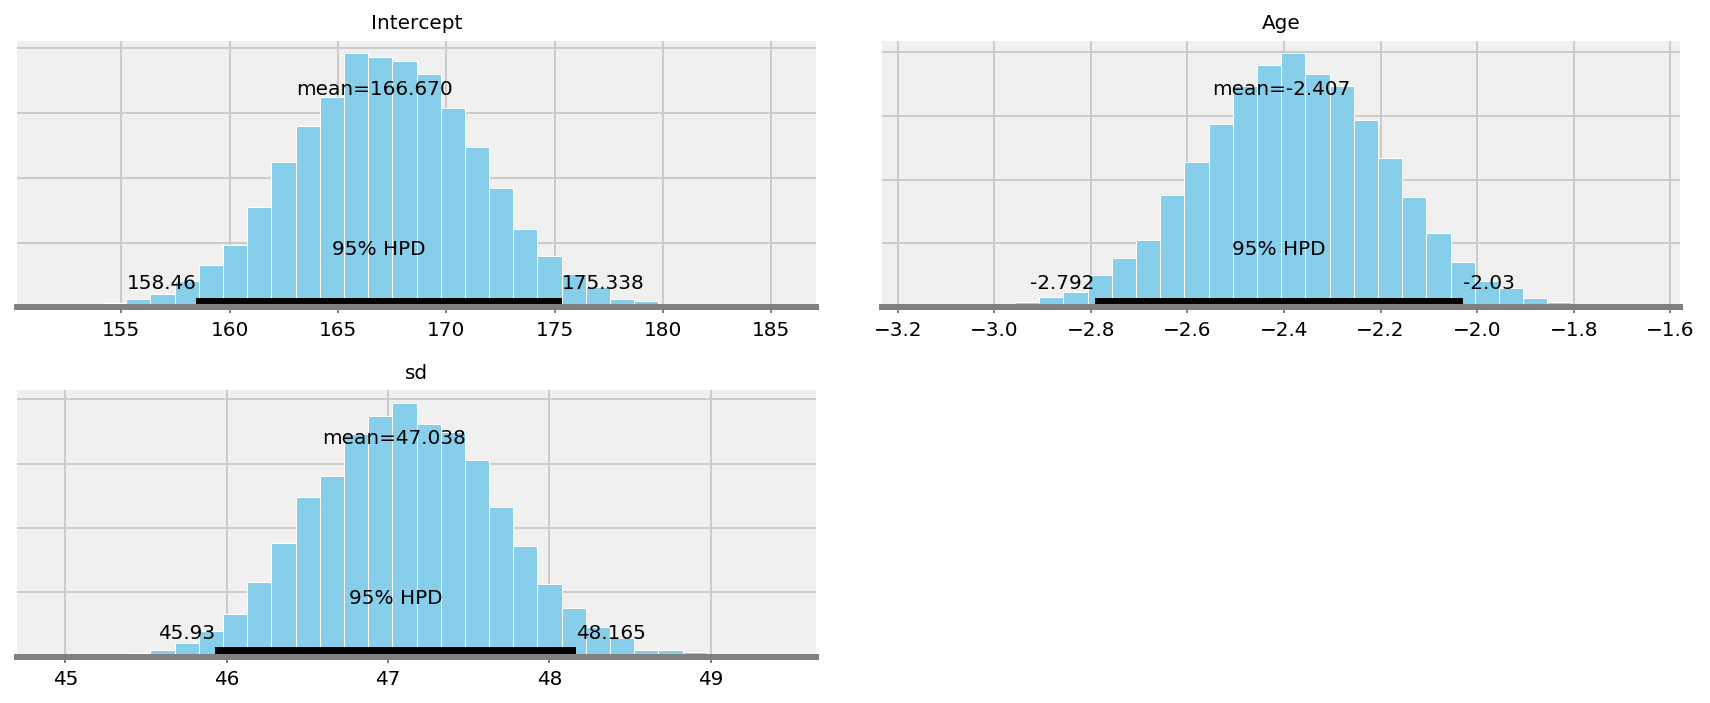

In [41]:
# posterior distributions
pm.plot_posterior(trace[500:],color='#87ceeb')
plt.show()

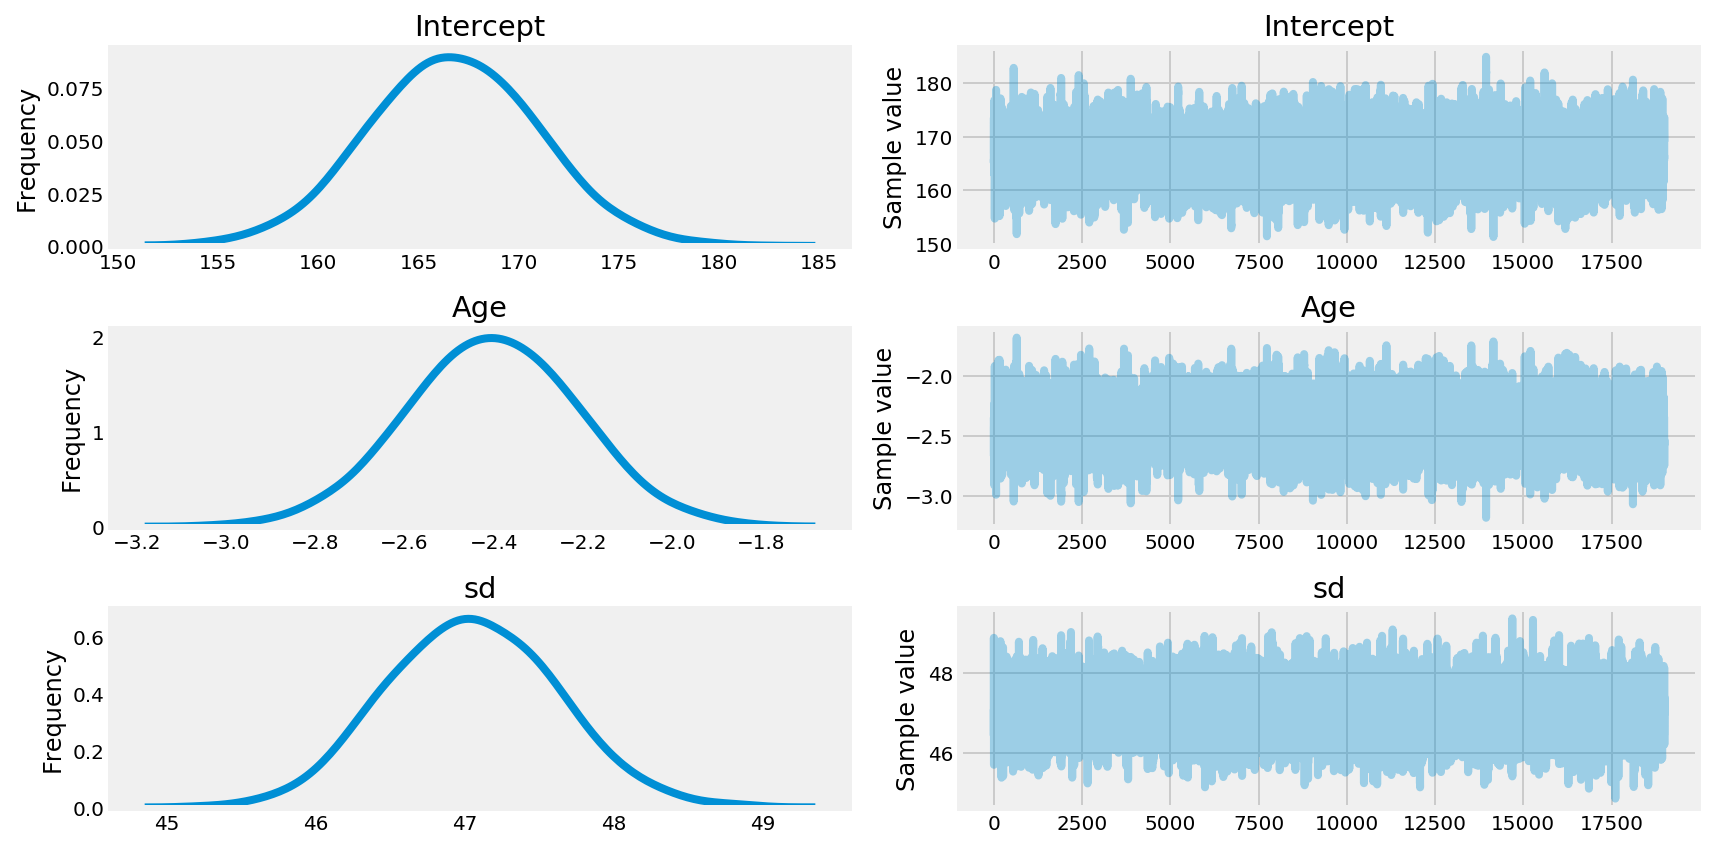

In [42]:
# trace plots
pm.traceplot(trace[500:],combined=True)
plt.tight_layout()

In [43]:
# summary
pm.summary(trace[500:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,166.6699,4.2786,0.0578,158.4596,175.3381,5142.3240,1.0007
Age,-2.4065,0.1939,0.0026,-2.7920,-2.0301,5142.9928,1.0007
sd,47.0383,0.5757,0.0063,45.9297,48.1646,9739.6202,1.0003


In [44]:
# first trace element
trace[0]

{'Age': -2.2950447093643573,
 'Intercept': 165.2276683715798,
 'sd': 46.86371478155918,
 'sd_log__': 3.8472437039785845}

Given our posterior distribution, represented through the trace, and our model, we can sample y-values.

In [45]:
preds = pm.sample_ppc(trace, model=reg)

print(preds['y'].shape)

100%|██████████| 10000/10000 [00:05<00:00, 1832.69it/s]


(10000, 3340)


#### Averaging over all samples allows to calculate the usual R2 score:

In [46]:
from sklearn.metrics import r2_score

r2_score(apm_age.APM, preds['y'].mean(axis=0))

0.04438640287243878

> **Note:** The pymc3.r2_score calculates an R2 score adapted for Bayesian modeling which is **not(!)** our usual R2 score.

r2_r(r2_median=0.347519, r2_mean=0.347519, r2_std=0.0)


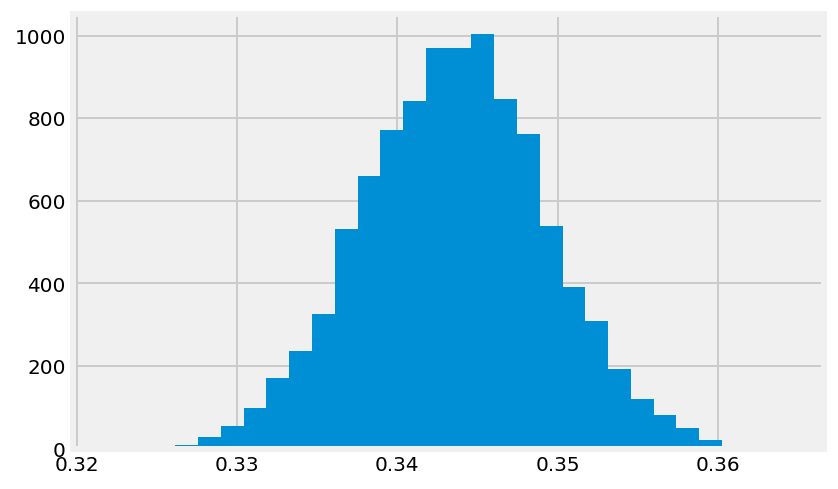

In [47]:
print(pm.r2_score(apm_age.APM,preds['y'][10],round_to=6))

r2_scores = [pm.r2_score(apm_age.APM,preds['y'][i],round_to=6).r2_mean for i in range(len(trace))]

plt.hist(r2_scores,bins=30)
plt.show()

#### Lastly, you can plot out different possible regression lines with `pm.glm.plot_posterior_predictive`.

This function takes:

- the trace (MCMC samples)
- the number of samples you want to draw and plot
- an `lm=` argument that will be a function defining how the regression line will be fit using an x value and the sample
- an `eval=` argument that will be the x-values `lm` is evaluated over

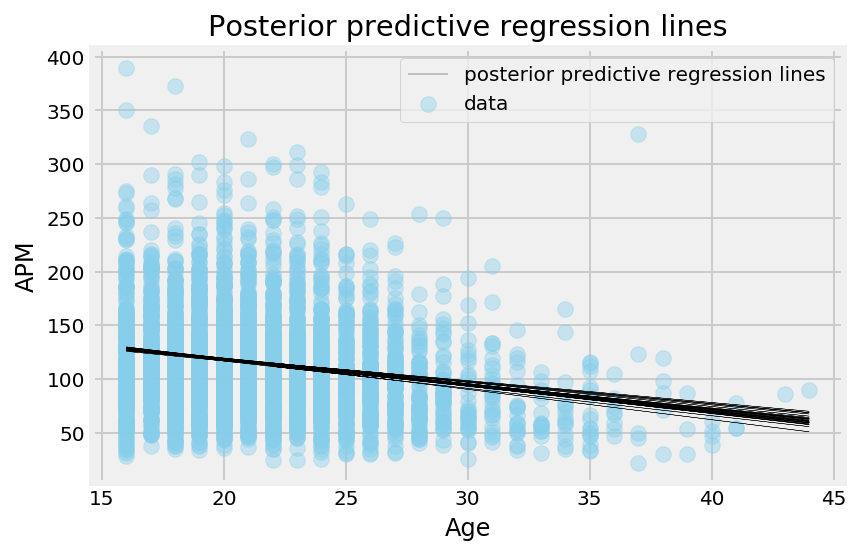

In [48]:
apm_age.plot(kind='scatter',x='Age',y='APM',c='#87ceeb',s=60,alpha=0.4,label='data')

pm.plot_posterior_predictive_glm(trace[500:], samples=25, 
                                 lm=lambda x, sample: sample['Intercept'] + sample['Age']*x,
                                 eval=apm_age.Age.values,
                                 label='posterior predictive regression lines'
                                 )

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('Age')
plt.ylabel('APM')

plt.show()

#### Compare to the sklearn result

In [49]:
from sklearn.linear_model import LinearRegression

X = apm_age[['Age']]
y = apm_age.APM

lr = LinearRegression()
lr.fit(X,y)

print(lr.intercept_, lr.coef_[0])

166.69388106887695 -2.4077083617787256


In [50]:
lr.score(X,y)

0.0443348866717832

<a id='conclusions'></a>
## Conclusions

We saw how to use pymc3 for Bayesian hypothesis testing and linear regression.
The essential points are 

- set up the models
- define some distributions for the prior and likelihood function
- run MCMC simulations 
- obtain the posterior distribution 

The results are collected in a trace and convenient plotting functions are provided.

### Additional Resources

- [Pymc3 reference](http://docs.pymc.io/index.html)
- [John Kruschke: Doing Bayesian Data Analysis](http://www.indiana.edu/~kruschke/DoingBayesianDataAnalysis/)
- [Andrew Gelman's blog](http://andrewgelman.com)
- [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)